In [1]:
%matplotlib inline
import xarray as xr
import tqdm
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import cmocean as cm
import os
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcbar
from IPython.display import HTML, display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import scipy.ndimage as ndimage
from tqdm import tqdm
warnings.filterwarnings('ignore')


In [2]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.05,-122.3)
    ax.set_ylim(37.5,38.)
    return(fig, ax)

def make_map_colorbar():
    fig = plt.figure(figsize=(12,9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1],hspace=.75)
    cart_proj = ccrs.PlateCarree()
    ax = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.05,-122.3)
    ax.set_ylim(37.5,38.)
    ax_cb = fig.add_subplot(gs[1])
    return(fig, ax, ax_cb)


In [3]:
def plot_radars(current_time, radar, ax):
    ''' '''
    current_radar = radar.sel(lat=slice(37.244221, 38.233120),lon=slice(-123.99,  -122.177032)).sel(time=current_time,method='nearest')
    current_radar['speed'] = np.sqrt(current_radar['u']**2 + current_radar['v']**2)
    u = current_radar['u']
    v = current_radar['v']
    x = current_radar['lon'].values
    y = current_radar['lat'].values
    xx,yy = np.meshgrid(x,y)
    # current_radar['speed'].plot(alpha=.5)
    cax = plt.contourf(x,y,current_radar['speed'],vmin=0,vmax=1,alpha=.75)
    plt.colorbar(cax)
    q = ax.quiver(xx,yy,u,v)

# This is a function to make a custome color map for the bathymetry
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with n colors
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """
    cmap = mcolors.LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

def make_bathy_map(bathy):
    fig, ax, ax_tides = make_map_colorbar()
    if bathy is not None:
        y = bathy['x'].values
        x = bathy['y'].values
        xx,yy = np.meshgrid(y,x)
        elv = bathy['z'].values
        elv_smooth = ndimage.gaussian_filter(elv, sigma=2, order=0) # This is a smoothing function for the contours
        elv[elv>.5] = np.nan # This removes replaces all data that is above 0.5 meters in elevation

        # Set the levels for the plotting bathymetery (ie detph contours)
        blevels = np.concatenate((np.arange(-150,-40,20),np.arange(-40,1,5))) 
        N = len(blevels)-1
        bnorm = matplotlib.colors.BoundaryNorm(blevels, ncolors=N, clip=False)
        cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
        cmap2.set_over('0.7') # light gray for anything above 0 meters

        # Contour colors
        pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both',alpha=.75)
        plt.colorbar(pc, ticks=blevels,fraction=0.026, pad=0.02)

        # Contour lines
        # ax.contour(xx,yy,elv_smooth,levels=[-1], colors='red',zorder=20) # Highlight coastline (ie 1 meter isobath)
        ax.contour(xx,yy,elv_smooth,levels=[-20], colors='black',zorder=20) # Highlight 20 meter isobath 

    # THis is all formating stuff
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True) # This maps the gridlines, which are basically straight at this scale
    # # # Turn off the lable ticks
    gl.xlines = False
    gl.ylines = False

    gl.xlabels_top = False
    gl.ylabels_right = False
    return fig, ax, ax_tides


def plot_radars(current_time, radar, ax):
    ''' '''
    current_radar = radar.sel(lat=slice(37.244221, 38.233120),lon=slice(-123.99,  -122.177032)).sel(time=current_time,method='nearest')
    current_radar['speed'] = np.sqrt(current_radar['u']**2 + current_radar['v']**2)
    u = current_radar['u']
    v = current_radar['v']
    x = current_radar['lon'].values
    y = current_radar['lat'].values
    xx,yy = np.meshgrid(x,y)
    # current_radar['speed'].plot(alpha=.5)
#     cax = plt.contourf(x,y,current_radar['speed'],vmin=0,vmax=1,alpha=.75)
#     plt.colorbar(cax)
    q = ax.quiver(xx,yy,u,v,zorder=100)



## Continuous Data

__Data are saved at a netcdf file where the main coordinates are (`trajectory`, `time`, `lon`, `lat`). There are also data variables that may useful, status indicates if the paricle is ruinning (0), stopped (1) or not yet deployed (-3E23)__

__Load HFR vectors__

In [13]:
hfr2 = xr.open_dataset("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd")

__Load Bathymetry Data__

In [14]:
# make negative contours, normally dashed by default, be solid
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'      
try:
    bathy = xr.open_dataset('https://www.ngdc.noaa.gov/thredds/dodsC/crm/crm_vol7.nc')
    bathy = bathy.sel(y=slice(36.244221, 38.233120),x=slice(-123.99,  -122.177032))
except:
    bathy=None

__Load Particle Tracks__

In [11]:
ds = xr.open_dataset('~/SurfaceCurrentMaps/DailyModelRuns/model_output/concave_hrf_20210120T012700_continuous.nc')
start_time = ds['time'].values[0]
df = ds['status'].to_dataframe()
# df = df[df['status'] >= 0  ] # remove data rows were trajectory is not yet deployed
# df['start_group'] = 0

__Load Tide Data__

In [18]:
time_df = ds['time'].to_pandas().dt.strftime('%Y%m%d')
# 20201204
tides = pd.read_csv("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={}&end_date={}&station=9414290&product=water_level&datum=MLLW&time_zone=gmt&units=metric&format=csv".format(time_df.iloc[0],time_df.iloc[-1]))
tides['dateTime'] = pd.to_datetime(tides['Date Time'])
tides.index = tides.dateTime

__Load Particle Tracks__

In [19]:
# start_time
for i in range(1,501):
    time_diff = df.loc[(i)].index[0] - start_time
    time_diff = int(time_diff.total_seconds() / 3600)
    df.loc[(i)]['start_group'] = time_diff

In [28]:
i= 500
time_diff = df.loc[(i)].index[0] - start_time
print(time_diff)
time_diff = int(time_diff.total_seconds() / 3600)
print(time_diff)

0 days 04:30:00
4


In [12]:
norm = mcolors.Normalize(vmin=0, vmax=24)
start_time_ts = df.index.get_level_values(1)[0]
for j, t in enumerate(tqdm(pd.to_datetime(ds['time'].values))):
# j = 30
# t = df.index.get_level_values(1)[30]
    current_time = t
    tail_time = current_time - timedelta(hours=3)
    bathy=None
    fig, ax, ax_tide = make_bathy_map(bathy=bathy)
    plot_radars(t, hfr2, ax)
    for i in range(1,501):
        current_df = df.loc[(i)]
        if (current_time - start_time_ts).total_seconds() <= (6 * 60):
            plot_df = current_df.query("time <= @current_time")
        else:
            plot_df = current_df.query("time <= @current_time & time >= @tail_time")

        if plot_df.size != 0:
            # Particles that are done
            if np.any(plot_df['status'] == 1):
                ax.scatter(plot_df.iloc[-1]['lon'], plot_df.iloc[-1]['lat'],marker='x', c=np.array([cm.cm.algae(norm(plot_df['start_group'].iloc[0]))]));
            # plot the past 6 hours and the current location
            else:
                ax.plot(plot_df['lon'], plot_df['lat'], color=cm.cm.algae((norm(plot_df['start_group'].iloc[0]))),alpha=.75);
                im = ax.scatter(plot_df.iloc[-1]['lon'], plot_df.iloc[-1]['lat'], c=np.array([cm.cm.algae(norm(plot_df['start_group'].iloc[0]))]),zorder=210, edgecolors='k');
    plt.text(.02,.95,"time step: {}".format(j), transform=ax.transAxes)
    plt.text(.02,.925,"time: {}".format(current_time), transform=ax.transAxes)
    # cbar = plt.colorbar(im,cmap=cm.cm.algae, norm=norm)
    # cbar.set_clim(1,24)
    ax_cb, _ = mcbar.make_axes(ax, shrink=.5,orientation='horizontal',pad=0,anchor=(.1,1.75))
    cbar = mcbar.ColorbarBase(ax_cb, cmap=cm.cm.algae,norm=norm,orientation='horizontal',)

    ax_tide.plot(tides['dateTime'],tides[' Water Level'])
    current_tide = (tides.index.get_loc(current_time, method='nearest'))
    ax_tide.scatter(tides.index[current_tide],tides[' Water Level'].iloc[current_tide],c='r',marker='x',s=60,zorder=120)
    ax_tide.set_ylabel('water level [m]')
    plt.savefig(f"Data/model_output/animation_cont/sfBay_01_frame_{j:04}.png")
    plt.close()

100%|██████████| 193/193 [11:40<00:00,  3.63s/it]


In [31]:
import glob
from PIL import Image

In [32]:
# filepaths
fp_in = "Data/model_output/animation_cont/sfBay_01_frame*png"
fp_out = "Data/model_output/animation_cont/cont_sfgate_animation_large.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)


In [8]:
model_output = '../DailyModelRuns/model_output/concave_hrf_20210127T090600_continuous.nc'
ds = xr.open_dataset(model_output)

In [9]:
ds

<xarray.Dataset>
Dimensions:                                                                              (time: 193, trajectory: 1250)
Coordinates:
  * trajectory                                                                           (trajectory) int32 ...
  * time                                                                                 (time) datetime64[ns] ...
    lon                                                                                  (trajectory, time) float32 ...
    lat                                                                                  (trajectory, time) float32 ...
Data variables:
    status                                                                               (trajectory, time) int32 ...
    moving                                                                               (trajectory, time) int32 ...
    age_seconds                                                                          (trajectory, time) float32 ...
    origin_marker                                                                        (trajectory, time) int16 ...
    z                                                                                    (trajectory, time) float32 ...
    wind_drift_factor                                                                    (trajectory, time) float32 ...
    terminal_velocity                                                                    (trajectory, time) float32 ...
    x_sea_water_velocity                                                                 (trajectory, time) float32 ...
    y_sea_water_velocity                                                                 (trajectory, time) float32 ...
    x_wind                                                                               (trajectory, time) float32 ...
    y_wind                                                                               (trajectory, time) float32 ...
    upward_sea_water_velocity                                                            (trajectory, time) float32 ...
    ocean_vertical_diffusivity                                                           (trajectory, time) float32 ...
    sea_surface_wave_significant_height                                                  (trajectory, time) float32 ...
    sea_surface_wave_stokes_drift_x_velocity                                             (trajectory, time) float32 ...
    sea_surface_wave_stokes_drift_y_velocity                                             (trajectory, time) float32 ...
    sea_surface_wave_period_at_variance_spectral_density_maximum                         (trajectory, time) float32 ...
    sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment  (trajectory, time) float32 ...
    surface_downward_x_stress                                                            (trajectory, time) float32 ...
    surface_downward_y_stress                                                            (trajectory, time) float32 ...
    turbulent_kinetic_energy                                                             (trajectory, time) float32 ...
    turbulent_generic_length_scale                                                       (trajectory, time) float32 ...
    sea_floor_depth_below_sea_level                                                      (trajectory, time) float32 ...
    land_binary_mask                                                                     (trajectory, time) float32 ...
Attributes:
    Conventions:                                  CF-1.6
    standard_name_vocabulary:                     CF-1.6
    featureType:                                  trajectory
    history:                                      Created 2021-01-29 00:00:59...
    source:                                       Output from simulation with...
    model_url:                                    https://github.com/OpenDrif...
    opendrift_class:                              OceanDrift
   

In [8]:
start_time = ds['time'].values[0]
df = ds['status'].to_dataframe()
df = df[df['status'] >= 0  ] # remove data rows were trajectory is not yet deployed
df['start_group'] = 0

# Load Tide Data
time_df = ds['time'].to_pandas().dt.strftime('%Y%m%d')
for i in range(1,501):
    time_diff = df.loc[(i)].index[0] - start_time
    time_diff = int(time_diff.total_seconds() / 3600)
    df.loc[(i)]['start_group'] = time_diff

norm = mcolors.Normalize(vmin=0, vmax=24)
start_time_ts = df.index.get_level_values(1)[0]

last_pos = df.query('status == 1')
# ## Loop through each timestep and make an image for each frame.
# for j, t in enumerate(tqdm(pd.to_datetime(ds['time'].values))):
#     current_time = t
#     tail_time = current_time - timedelta(hours=3)



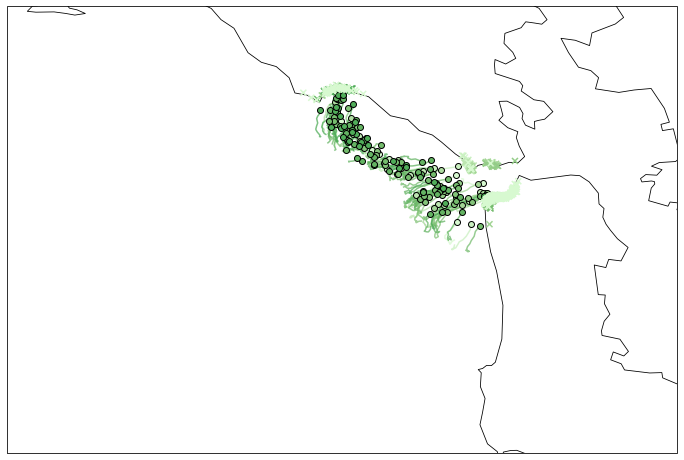

In [46]:
times = pd.to_datetime(ds['time'].values)
current_time = times[125]
tail_time = current_time - timedelta(hours=3)

fig, ax = make_map()
for i in range(1,501):
    current_df = df.loc[(i)]
    if (current_time - start_time_ts).total_seconds() <= (6 * 60):
        plot_df = current_df.query("time <= @current_time")
    else:
        plot_df = current_df.query("time <= @current_time & time >= @tail_time")

    if plot_df.size != 0:
        # Particles that are done
        if np.any(plot_df['status'] == 1):
            ax.scatter(plot_df.iloc[-1]['lon'], plot_df.iloc[-1]['lat'],marker='x', c=np.array([cm.cm.algae(norm(plot_df['start_group'].iloc[0]))]));
        # plot the past 6 hours and the current location
        else:
            ax.plot(plot_df['lon'], plot_df['lat'], color=cm.cm.algae((norm(plot_df['start_group'].iloc[0]))),alpha=.75);
            im = ax.scatter(plot_df.iloc[-1]['lon'], plot_df.iloc[-1]['lat'], c=np.array([cm.cm.algae(norm(plot_df['start_group'].iloc[0]))]),zorder=210, edgecolors='k');

out_of_model = last_pos.query('time <= @current_time')
ax.scatter(out_of_model['lon'],out_of_model['lat'],c=np.array([cm.cm.algae(norm(out_of_model['start_group']))])[0],zorder=211, edgecolors='k',marker='x')

In [45]:
last_pos = df.query('status == 1')
print(current_time)
last_pos.query('time <= @current_time').shape


2021-01-28 16:21:00


(861, 4)

In [35]:
last_pos['start_group'].shape

(1196,)

### Creating JSON for plotting ###

<xarray.Dataset>
Dimensions:                                                                              (time: 193, trajectory: 1250)
Coordinates:
  * trajectory                                                                           (trajectory) int32 ...
  * time                                                                                 (time) datetime64[ns] ...
    lon                                                                                  (trajectory, time) float32 ...
    lat                                                                                  (trajectory, time) float32 ...
Data variables:
    status                                                                               (trajectory, time) int32 ...
    moving                                                                               (trajectory, time) int32 ...
    age_seconds                                                                          (trajectory, time) float32 ...
    origin_marker                                                                        (trajectory, time) int16 ...
    z                                                                                    (trajectory, time) float32 ...
    wind_drift_factor                                                                    (trajectory, time) float32 ...
    terminal_velocity                                                                    (trajectory, time) float32 ...
    x_sea_water_velocity                                                                 (trajectory, time) float32 ...
    y_sea_water_velocity                                                                 (trajectory, time) float32 ...
    x_wind                                                                               (trajectory, time) float32 ...
    y_wind                                                                               (trajectory, time) float32 ...
    upward_sea_water_velocity                                                            (trajectory, time) float32 ...
    ocean_vertical_diffusivity                                                           (trajectory, time) float32 ...
    sea_surface_wave_significant_height                                                  (trajectory, time) float32 ...
    sea_surface_wave_stokes_drift_x_velocity                                             (trajectory, time) float32 ...
    sea_surface_wave_stokes_drift_y_velocity                                             (trajectory, time) float32 ...
    sea_surface_wave_period_at_variance_spectral_density_maximum                         (trajectory, time) float32 ...
    sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment  (trajectory, time) float32 ...
    surface_downward_x_stress                                                            (trajectory, time) float32 ...
    surface_downward_y_stress                                                            (trajectory, time) float32 ...
    turbulent_kinetic_energy                                                             (trajectory, time) float32 ...
    turbulent_generic_length_scale                                                       (trajectory, time) float32 ...
    sea_floor_depth_below_sea_level                                                      (trajectory, time) float32 ...
    land_binary_mask                                                                     (trajectory, time) float32 ...
Attributes:
    Conventions:                                  CF-1.6
    standard_name_vocabulary:                     CF-1.6
    featureType:                                  trajectory
    history:                                      Created 2021-01-22 14:45:20...
    source:                                       Output from simulation with...
    model_url:                                    https://github.com/OpenDrif...
    opendrift_class:                              OceanDrift
   